In [ ]:
# %pip install python-dotenv dashscope requests matplotlib pillow langchain langchain_community

In [1]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

In [2]:
from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatTongyi

image_description_prompt = """你是一个精通文字编辑和图片处理的专家，你会根据我给出的文字内容生成一段图片描述，该图片会作为给出的文字内容的特色图片（特色图片featured image代表博客或页面的文字内容，情绪或主题，并在整个网站中使用），要求：
1. 该描述能够帮助AI理解并生成与文字内容相关的图片；
2. 该描述能够概括出文字内容中的主要信息和主题，为了让图片更有创意性，你可适当的增加天马行空的元素和描述；
3. 你会从图片专家的角度思考，描述中尽量包括图片中心主题，环境信息，图片中的物体位置、图片中的物体大小、图片中的物体颜色、图片中的物体形状、图片中的物体材质、图片中的物体风格、图片中的物体数量、图片中的物体关系等等；
4. 同时你还会给出图片艺术风格的描述，具体图片艺术风格你可以根据自己对给出的文字内容的理解自行决定，图片风格你只可以从如下选项中选择：
    - <photography>：摄影。
    - <portrait>：人像写真。
    - <3d cartoon>：3D卡通。
    - <anime>：动画。
    - <oil painting>：油画。
    - <watercolor>：水彩。
    - <sketch>：素描。
    - <chinese painting>：中国画。
    - <flat illustration>：扁平插画。；
5. 你会从图片专家的角度思考，给出一些用于AI生成图片时可以利用的技术参数从而让图片变得更加美观，你可以根据自身对图片以及美观的理解自行选择需要设置的图片技术参数例如近景镜头、半身特写、锐化等等；

文字内容如下：
{text}
"""

text_context = """
在大模型 LLM 微调、RAG 等技术经常会碰到 vector embeddings、text embeddings 的概念，特别是使用向量数据库做模型训练、查询、比较等场景下，所以我打算研究一下，vector embeddings 到底是什么。

## vector embeddings 的感性理解
![[Pasted image 20241128195412.png]]
vector embeddings 的出现最本质的原因是科学家为了解决一个问题 —— 让只认识0、1数字，只会做逻辑运算和浮点运算的计算机，能够理解人类语言、文字、图像、视频等数据包含的语义以及它们之间的关系。例如，「泰迪」、「狗」、「犬」、「哺乳动物」这几个单词在不同的上下文中其实是同一个意思，即一种四足、有尾巴、有尖牙的哺乳动物，这就是文字、图像、视频中包括的语义信息，科学家希望计算机可以理解这些。

既然计算机只认识数字，只会做运算，科学家的想法很直接，那就我们就将人类使用的文字、句子、文章、书本、图像、视频等等非结构化的数据转换成数字来描述，帮助计算机高效的理解和处理它们，于是就有了 vector embeddings。

## vector embeddings 是什么
vector embeddings（向量嵌入）是一种将单词、句子和其他数据转换为数字的方法，这些数字捕获了它们的含义和关系。它们将不同类型的数据表示为高维空间（多维空间）中的点，其中相似的数据点聚集在一起。这些数值表示有助于机器更有效地理解和处理这些数据。

向量嵌入在处理语义相似度时至关重要。vector（向量）仅仅是一系列数字；vector embedding（向量嵌入）是一系列代表输入数据的数字。通过使用 vector embeddings，我们可以结构化非结构化数据或通过将其转换为一系列数字来处理任何类型的数据。这种方法使我们能够对输入数据执行数学运算，而不是依赖定性比较。

## vector V.S. embedding
在 vector embeddings （向量嵌入）的上下文中，embedding（嵌入）和 vector（向量）是同一回事。两者都指数据的数值表示，其中每个数据点都由高维空间中的向量表示。

“vector 向量”仅指具有特定维数的数字数组。在 vector embedding（向量嵌入）的情况下，这些向量表示上述任何数据点在一个连续的空间中。

“embedding 嵌入”专门指将数据表示为 vector（向量）的技术，以捕获有意义的信息、语义关系或上下文特征。embedding 嵌入旨在捕获数据的底层结构或属性，通常通过训练算法或模型来学习。

虽然嵌入和向量可以在向量嵌入的上下文中互换使用，“嵌入”强调以有意义和结构化的方式表示数据的概念，而“向量”则指数值表示本身。

## 如何构建 vector embeddings
![[Pasted image 20241128200934.png]]
vector embeddings 是深度学习模型中输入数据的内部表示，也称为嵌入模型或深度神经网络。那么，我们如何提取这些信息呢？

我们通过移除最后一层并从倒数第二层获取输出，来获得 vector 向量。神经网络的最后一层通常输出模型的预测，因此我们取倒数第二层的输出。vector embedding（向量嵌入）是馈送到神经网络预测层的数据。

vector embedding（向量嵌入）的维数等于模型中倒数第二层的尺寸，因此与向量的尺寸或长度可互换。常见的向量维数包括384（例如 Sentence Transformers Mini-LM 生成的 vector）、768（例如 Sentence Transformers MPNet 生成的 vector）、1,536（例如 OpenAI 生成的 vector）和2,048（例如 ResNet-50 生成的 vector）。

### 奇怪的 vector embeddings 维数 768、1024、1536、2048
最早的 GPT-2 设置中，头的数量是 12（dimension heads），它可以整除 768。

这个数字来自于超参数优化（hyperparameter optimization）。使用 4096 大小的嵌入和 1 层的神经网络，或者使用 16 大小的嵌入和 2B 参数的神经网络是没有意义的，这些值之间需要一个良好的平衡。

那么为什么是 768 而不是 769 呢？我们通常使用 2 的幂（或接近的值）来尝试超参数，因为它们在计算上更快，并且更适合 GPU 内存分配（就像你的屏幕分辨率一样，GPU 只是一个计算矩阵的大型机器）。`768 = 512 + 256 = 2**9 + 2**8`。

### vector embeddings 维度的含义
我曾经查找资料并试图弄懂 vector embeddings（向量嵌入）中每个维度的含义。最终的答案是，单个维度没有任何意义。vector embeddings 中的单个维度过于抽象，无法确定其含义。然而，当我们将所有维度放在一起时，它们提供了输入数据的语义含义。

向量的维度是不同属性的高级抽象表示。表示的属性取决于训练数据和模型本身。文本和图像模型生成不同的嵌入，因为它们针对根本不同的数据类型进行训练。即使是不同的文本模型也会生成不同的嵌入。有时它们在大小上不同；其他时候，它们在表示的属性上不同。例如，在法律数据上训练的模型将学习与在医疗保健数据上训练的模型不同的事物。

## 图像 vector embeddings
2012 年 AlexNet 的出现标志着图像识别技术的飞跃。自那时以来，计算机视觉领域取得了无数进展。最新的知名图像识别模型是 ResNet-50，它是一个基于前代 ResNet-34 架构的 50 层深度残差网络。
![[Pasted image 20241128201952.png]]

尝试使用 [microsoft/resnet-50 · Hugging Face](https://huggingface.co/microsoft/resnet-50)生成图像的 vector embeddings：
```python
# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image


extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

image = Image.open("<image path>")
# image = Resize(size=(256, 256))(image)

inputs = extractor(images=image, return_tensors="pt")
# print(inputs)

outputs = model(**inputs)
vector_embeddings = outputs[1][-1].squeeze()
```

## 文本 vector embeddings
人工智能对自然语言的处理已经从基于规则的嵌入发展到了一个新的高度。从最初的神经网络开始，我们通过 RNN 添加了递归关系来跟踪时间步长。从那时起，我们使用 Transformer 来解决序列转导问题。

Transformer 由编码器、注意力矩阵和解码器组成。编码器将输入编码为表示状态的矩阵，注意力矩阵和解码器对状态和注意力矩阵进行解码，以预测正确的下一个标记来完成输出序列。GPT 是迄今为止最流行的语言模型，它由严格的解码器组成。它们对输入进行编码并预测正确的下一个标记。

尝试使用 [sentence-transformers](https://huggingface.co/sentence-transformers)生成文本的 vector embeddings：
```python
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("<model-name>")
vector_embeddings = model.encode(“<input>”)
```

## 多模态 vector embeddings
以图生文为例，使用开源模型 [CLIP VIT](https://huggingface.co/openai/clip-vit-large-patch14) 来生成 embeddings：
```python
# Load model directly
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification


processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")
from PIL import Image


image = Image.open("<image path>")
# image = Resize(size=(256, 256))(image)


inputs = extractor(images=image, return_tensors="pt")
# print(inputs)


outputs = model(**inputs)
vector_embeddings = outputs[1][-1].squeeze()
```

## 语音 vector embeddings
以语音生成文字为例，使用开源模型 [Whisper](https://huggingface.co/openai/whisper-large-v2) 模型来获取 embedding：
```python
import torch
from transformers import AutoFeatureExtractor, WhisperModel
from datasets import load_dataset


model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
inputs = feature_extractor(ds[0]["audio"]["array"], return_tensors="pt")
input_features = inputs.input_features
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
vector_embedding = model(input_features, decoder_input_ids=decoder_input_ids).last_hidden_state
```

## 视频 vector embeddings
视频的 embeddings 比语音、图片的 embeddings 更加复杂，它需要多模态的处理来保证语音与图片的同步，以 DeepMind 开源模型 [multimodal perceiver](https://huggingface.co/deepmind/multimodal-perceiver) 为例生成视频的 vector embeddings（注意代码 `outputs[1][-1].squeeze()`)：
```python
def autoencode_video(images, audio):
     # only create entire video once as inputs
     inputs = {'image': torch.from_numpy(np.moveaxis(images, -1, 2)).float().to(device),
               'audio': torch.from_numpy(audio).to(device),
               'label': torch.zeros((images.shape[0], 700)).to(device)}
     nchunks = 128
     reconstruction = {}
     for chunk_idx in tqdm(range(nchunks)):
          image_chunk_size = np.prod(images.shape[1:-1]) // nchunks
          audio_chunk_size = audio.shape[1] // SAMPLES_PER_PATCH // nchunks
          subsampling = {
               'image': torch.arange(
                    image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
               'audio': torch.arange(
                    audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
               'label': None,
          }
     # forward pass
          with torch.no_grad():
               outputs = model(inputs=inputs, subsampled_output_points=subsampling)


          output = {k:v.cpu() for k,v in outputs.logits.items()}
          reconstruction['label'] = output['label']
          if 'image' not in reconstruction:
               reconstruction['image'] = output['image']
               reconstruction['audio'] = output['audio']
          else:
               reconstruction['image'] = torch.cat(
                    [reconstruction['image'], output['image']], dim=1)
               reconstruction['audio'] = torch.cat(
                    [reconstruction['audio'], output['audio']], dim=1)
          vector_embeddings = outputs[1][-1].squeeze()
	 # finally, reshape image and audio modalities back to original shape
     reconstruction['image'] = torch.reshape(reconstruction['image'], images.shape)
     reconstruction['audio'] = torch.reshape(reconstruction['audio'], audio.shape)
     return reconstruction


     return None
```

## References
1. [Motivation to use 768 dimensional embeddings from Transformers?](https://www.reddit.com/r/MachineLearning/comments/mf8qlk/d_motivation_to_use_768_dimensional_embeddings/)
2. [How to Get the Right Vector Embeddings](https://medium.com/vector-database/how-to-get-the-right-vector-embeddings-83295ced7f35)
3. [What are Vector Embeddings?](https://www.elastic.co/what-is/vector-embedding)
"""


llm_model = "qwen-max"

llm = ChatTongyi(temperature=0.8, model=llm_model)

image_description_template = ChatPromptTemplate.from_template(image_description_prompt)

response = llm.invoke(image_description_template.format_messages(text=text_context))

image_description = response.content

print(response.content)

### 图片描述

**中心主题**：计算机通过向量嵌入（vector embeddings）理解人类语言、图像、视频等非结构化数据。

**环境信息**：一个充满科技感的未来实验室，背景中可以看到各种高科技设备和屏幕显示着复杂的数据流。整个场景被柔和的蓝光包围，给人一种宁静而专业的氛围。

**物体位置与大小**：
- **中央**：占据画面大部分空间的是一个巨大的透明立方体，里面充满了流动的彩色线条，代表高维空间中的向量嵌入。
- **左下角**：一个小机器人正用手指触摸立方体，展示它正在与这些数据互动。机器人身高约为立方体高度的1/5。
- **右上角**：几块悬浮的显示屏，上面展示了不同类型的输入数据（文本、图片、音频波形），每个显示屏宽度约为立方体宽度的1/3。
- **右下角**：一名穿着白色实验服的研究员坐在工作台前，专注地操作电脑，其身影略小于机器人，大约是立方体高度的1/6。

**物体颜色与形状**：
- **立方体**：半透明材质，内部由无数条动态变化的彩色线条构成，主要颜色为蓝色、绿色和紫色。
- **机器人**：金属质感，外观简洁流畅，有轻微的反光效果。
- **显示屏**：边缘发光，以冷色调为主，内容清晰可见。
- **研究员**：身着白色实验服，头发整齐，面部表情认真且充满好奇心。

**物体材质**：
- **立方体**：玻璃或亚克力材料，具有一定的透明度。
- **机器人**：金属合金，表面光滑。
- **显示屏**：高清液晶屏幕，边缘采用LED灯带装饰。
- **研究员**：衣物为棉质面料，实验服则带有防静电特性。

**物体风格**：
- 整体设计趋向于未来主义与科幻结合的风格，同时保持了科学实验室的专业性。

**艺术风格**：选择<flat illustration>扁平插画风格，因为它可以很好地平衡细节表现与视觉简洁性，使复杂的概念变得易于理解。

**技术参数建议**：
- 采用近景镜头来突出立方体内的向量流动，增强观者对核心主题的关注。
- 对于立方体及其内部线条应用轻微的模糊处理，营造出一种流动感，但要确保整体依然清晰可辨。
- 适当增加对比度，使得颜色更加鲜明，有助于区分不同元素之间的层次关系。
- 使用渐变色填充技术给立方体添加深度感，使其看起来更加立体而不失轻盈。
- 在关键部位如机器人手指触碰处加入微弱的光晕

Matplotlib is building the font cache; this may take a moment.


Image 1: https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/f0/20241130/59320e4c/6b02aa3f-02b8-46ab-a146-f829ceb783f9-1.png?Expires=1733065145&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=7G0kvXLeSGOn6cIIve0hECdcCYA%3D
Image 2: https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/24/20241130/59320e4c/fa86f8ae-5243-4a1a-ab99-100648c66342-1.png?Expires=1733065145&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=d7rlnHnilolIS%2B7gMqew6bUiX0Q%3D
Image 3: https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/78/20241130/59320e4c/2c3d8946-8f01-41f4-80ab-631d9ba22f8e-1.png?Expires=1733065145&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=XIQB%2FXfdJHH%2FjaHu2YrtlX%2FHpoU%3D
Image 4: https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/63/20241130/59320e4c/ffee731d-afcf-4057-b9ed-a3153c75668b-1.png?Expires=1733065145&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=2xcDnfq65RFzLJ6yyBmQAeT1q2g%3D


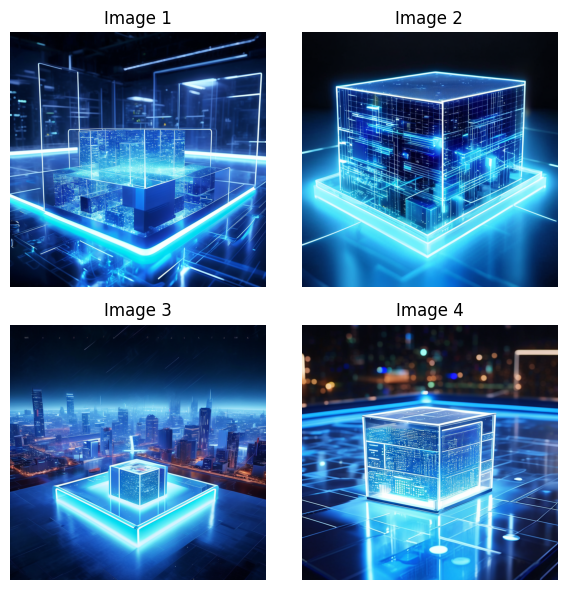

In [3]:
from http import HTTPStatus
import dashscope
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import os

def simple_call():
    urls = []
    prompt = image_description
    rsp = dashscope.ImageSynthesis.call(
        model=dashscope.ImageSynthesis.Models.wanx_v1,
        prompt=prompt,
        n=4,
        size="1024*1024",
        api_key=os.getenv("DASHSCOPE_API_KEY"),
    )
    if rsp.status_code == HTTPStatus.OK:
        # save file to current directory
        for result in rsp.output.results:
            urls.append(result.url)
    else:
        print(
            "Failed, status_code: %s, code: %s, message: %s"
            % (rsp.status_code, rsp.code, rsp.message)
        )

    return urls


def display_images_in_grid(image_urls):
    # 创建2x2的子图布局
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    # 扁平化axes数组以便更容易遍历
    axes_flat = axes.flatten()

    # 遍历每个图片URL
    for i, url in enumerate(image_urls):
        try:
            # 从URL获取图片
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))

            # 在对应的子图中显示图片
            axes_flat[i].imshow(img)
            axes_flat[i].axis("off")  # 关闭坐标轴
            axes_flat[i].set_title(f"Image {i+1}")
            print(f"Image {i+1}: {url}")

        except Exception as e:
            print(f"Error loading image {i+1}: {str(e)}")
            axes_flat[i].text(
                0.5, 0.5, f"Error loading\nImage {i+1}", ha="center", va="center"
            )
            axes_flat[i].axis("off")

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图表
    plt.show()


if __name__ == "__main__":
    image_urls = simple_call()
    display_images_in_grid(image_urls)